In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import sklearn.metrics
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import gridspec

### Experiment 3
Aim is to show that regularization is important. If you don't regularize, then you'll learn a sub-optimal policy

100%|██████████| 1/1 [00:00<00:00, 859.84it/s]
<ipython-input-4-b8b35f2f1761>:86: RuntimeWarning: invalid value encountered in true_divide
  beta = counts / counts.sum(axis=1, keepdims=True)
100%|██████████| 10000/10000 [00:00<00:00, 14878.47it/s]


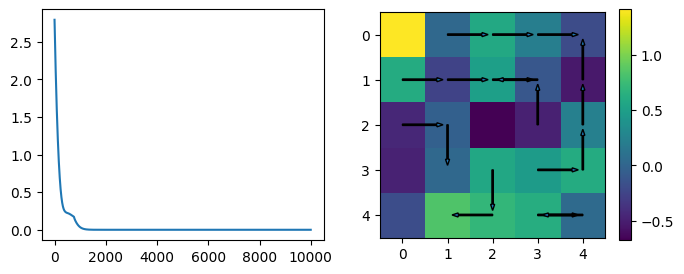

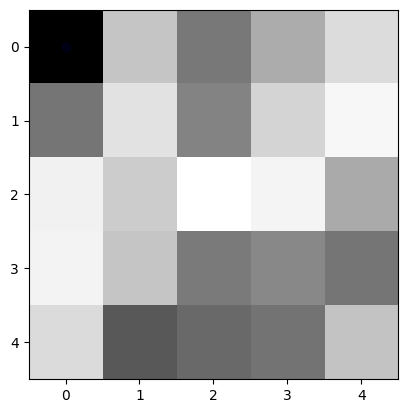

100%|██████████| 10000/10000 [00:00<00:00, 23619.54it/s]


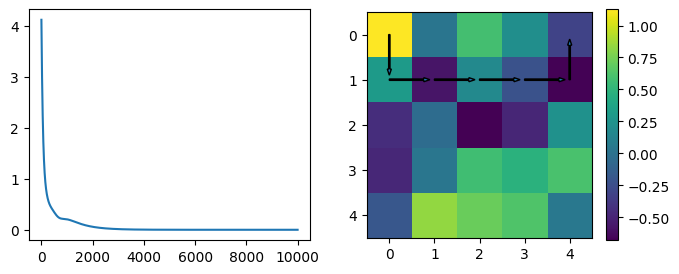

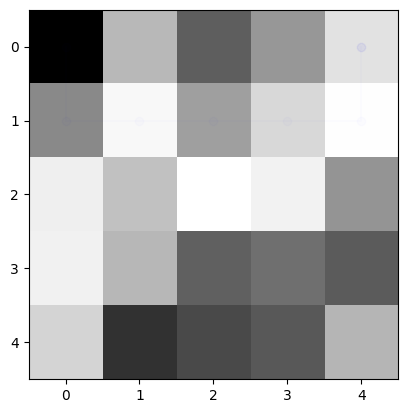

100%|██████████| 10000/10000 [00:01<00:00, 7865.45it/s]
UsageError: Line magic function `%download_file` not found.


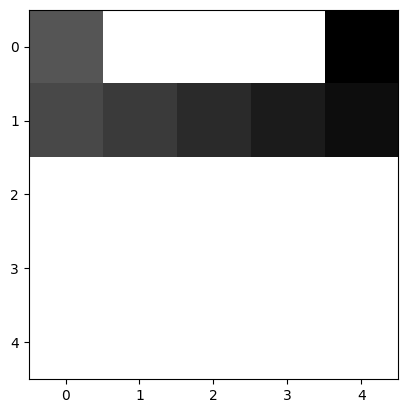

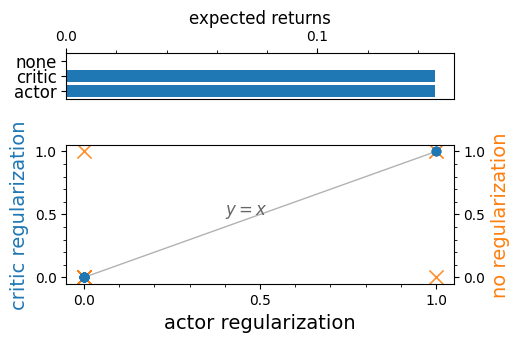

In [4]:
size = 5
num_states = size**2
num_actions = 5

def step(s, a):
  ij = np.array(np.unravel_index(s, (size, size)))
  if a == 0:
    ij[0] += 1
  elif a == 1:
    ij[1] += 1
  elif a == 2:
    ij[0] -= 1
  elif a == 3:
    ij[1] -= 1
  ij = ij.clip(0, size - 1)
  return np.ravel_multi_index(ij, (size, size))

def reward(s, a):
  return 0.01 * (s == 4).astype(float)

initial_state = 0

p_ns_given_sa = np.zeros((num_states, num_states, num_actions))
r_sa = np.zeros((num_states, num_actions))
for s in range(num_states):
  for a in range(num_actions):
    r_sa[s, a] = reward(np.array(s), a)
    ns = step(s, a)
    p_ns_given_sa[ns, s, a] = 1

def evaluate_pi(pi):
  p = np.zeros(num_states)
  p[initial_state] = 1
  p_ns_given_s = (p_ns_given_sa * pi[None]).sum(axis=-1)
  r_vec = []
  for t in range(1000):
    p_sa = p[:, None] * pi
    r = (r_sa * p_sa).sum()
    r_vec.append(r * gamma**t)
    p = p_ns_given_s @ p
  R1 = np.sum(r_vec)
  return R1

# collect static dataset
traj_vec = []

num_traj = 1
max_episode_steps = 10
np.random.seed(0)
for _ in tqdm.trange(num_traj):
  traj = []
  s = initial_state
  for __ in range(max_episode_steps):
    if s == 0:
      a = 0  # down
    elif s in [5, 6, 7, 8]:
      a = 1  # right
    elif s == 9:
      a = 2  # up
    else:
      a = 4  # nothing
    traj.append((s, a))
    s = step(s, a)
  traj_vec.append(traj)
traj_vec = np.array(traj_vec)  # (num_traj, max_episode_steps, 2)

# SARSA, Q-learning
gamma = 0.95
learning_rate = 1e-2

for q_learning in [True, False]:
  use_sarsa = not q_learning
  regularize_policy = not q_learning

  np.random.seed(0)
  Q = np.random.normal(size=(num_states, num_actions))
  s_vec = traj_vec[:, :-1, 0].flatten()
  ns_vec = traj_vec[:, 1:, 0].flatten()
  a_vec = traj_vec[:, :-1, 1].flatten()
  na_vec = traj_vec[:, 1:, 1].flatten()
  r_vec = reward(s_vec, a_vec)
  diff_vec = []

  counts = np.zeros((num_states, num_actions))
  np.add.at(counts, (s_vec, a_vec), 1)
  beta = counts / counts.sum(axis=1, keepdims=True)
  # assert np.all(np.isfinite(beta))

  for _ in tqdm.trange(10_000):
    if use_sarsa:
      V_vec = Q[ns_vec, na_vec]
      # V_vec = (Q[ns_vec] * beta[ns_vec]).sum(axis=-1)
    else:
      V_vec = Q[ns_vec].max(-1)
    td_update = r_vec + gamma * V_vec - Q[s_vec, a_vec]
    diff = np.linalg.norm(td_update)
    diff_vec.append(diff)
    np.add.at(Q, (s_vec, a_vec), learning_rate * td_update)


  # policy extraction
  if regularize_policy:
    pi = (Q * beta).clip(0, None)  # Ignore negative Q values
    pi = pi / pi.sum(axis=1, keepdims=True)  # Normalize the probabilities
  else:
    pi = np.zeros((num_states, num_actions))
    pi[np.arange(num_states), Q.argmax(axis=1)] = 1

  plt.figure(figsize=(8, 3))
  plt.subplot(121)
  plt.plot(diff_vec)
  plt.subplot(122)
  plt.imshow(Q.mean(-1).reshape((size, size)))
  for s in range(num_states):
    for a, prob in enumerate(pi[s]):
      ns = step(s, a)
      if s != ns:
        ij = np.array(np.unravel_index(s, (size, size)))
        delta = np.array(np.unravel_index(ns, (size, size))) - ij
        delta = 0.9 *prob * delta
        plt.arrow(ij[1], ij[0], delta[1], delta[0], width=0.03, length_includes_head=True)

  plt.colorbar()
  plt.show()
  plt.imshow(Q.mean(-1).reshape((size, size)), cmap='Greys')
  for _ in range(num_traj):
    traj = []
    s = initial_state
    for __ in range(max_episode_steps):
      a = np.random.choice(num_actions, p=pi[s])
      traj.append((s, a))
      s = step(s, a)
    traj = np.array(traj)
    i_vec, j_vec = np.unravel_index(traj[:, 0], (size, size))
    plt.plot(j_vec, i_vec, 'b-o', alpha=0.01)
  plt.show()
  if q_learning:
    Q3 = Q.copy()
    pi3 = pi.copy()
  else:
    Q1 = Q.copy()
    pi1 = pi.copy()

# critic regularization
gamma = 0.95
learning_rate = 1e-3

np.random.seed(0)
Q = np.random.normal(size=(num_states, num_actions))
s_vec = traj_vec[:, :-1, 0].flatten()
ns_vec = traj_vec[:, 1:, 0].flatten()
a_vec = traj_vec[:, :-1, 1].flatten()
na_vec = traj_vec[:, 1:, 1].flatten()
r_vec = reward(s_vec, a_vec)
diff_vec = []
pi = np.ones((num_states, num_actions)) / num_actions

for t in tqdm.trange(10_000):
  V_vec = (Q[ns_vec] * pi[ns_vec]).sum(axis=-1)

  pos_weights = np.zeros((num_states, num_actions))
  y = r_vec + gamma * V_vec
  np.add.at(pos_weights, (s_vec, a_vec), y / (y + 1))
  neg_weights = np.zeros((num_states, num_actions))
  w = pi[s_vec, a_vec] / beta[s_vec, a_vec]
  np.add.at(neg_weights, (s_vec, a_vec), w / (y + 1))
  # Add epsilon to make the classifier in (0, 1)
  opt_classifier = pos_weights / (pos_weights + neg_weights + 1e-6)
  # opt_classifier = opt_classifier.clip(1e-6, 1 - 1e-6)
  diff_vec.append(np.linalg.norm(Q - opt_classifier / (1 - opt_classifier)))
  Q = opt_classifier / (1 - opt_classifier)

  # Do a small update to pi to ensure convergence
  pi_new = np.zeros((num_states, num_actions))
  pi_new[np.arange(num_states), Q.argmax(axis=1)] = 1
  pi += learning_rate * (pi_new - pi)

Q2 = Q.copy()
pi2 = pi.copy()
plt.imshow(Q.mean(-1).reshape((size, size)), cmap='Greys')
for _ in range(num_traj):
  traj = []
  s = initial_state
  for __ in range(max_episode_steps):
    a = np.random.choice(num_actions, p=pi[s])
    traj.append((s, a))
    s = step(s, a)

c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
plt.subplot(gs[0])

pi1_nan = pi1.copy()
pi1_nan[np.isnan(pi1_nan)] = 1 / num_actions
R1 = evaluate_pi(pi1_nan)
R2 = evaluate_pi(pi2)
R3 = evaluate_pi(pi3)
x = np.arange(3)
plt.barh(x, [R1, R2, R3])
plt.xlabel('expected returns', fontsize=12)
plt.gca().xaxis.set_label_position('top') 
plt.yticks(x, ['actor', 'critic', 'none'], fontsize=12)
plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.02))
plt.gca().xaxis.tick_top()


plt.subplot(gs[1])
l = plt.plot([0, 1], [0, 1], '-', c='#666', linewidth=1, alpha=0.5)
plt.text(0.4, 0.5, '$y = x$', fontsize=12, c='#666')
plt.plot(pi1.flatten(), pi2.flatten(), 'o', alpha=0.5, c=c_vec[0])
plt.xlabel('actor regularization', fontsize=14)
plt.ylabel('critic regularization', fontsize=14, c=c_vec[0])
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.1))
ax = plt.gca()

plt.ylim([-0.05, 1.05])
ax2 = plt.twinx()
ax.set_zorder(ax2.get_zorder()+1)
ax.set_frame_on(False)

out = ax2.plot(pi1.flatten(), pi3.flatten(), 'x', c=c_vec[1], alpha=0.5, markersize=10)
ax2.set_ylabel('no regularization', fontsize=14, c=c_vec[1])
ax2.set_ylim([-0.05, 1.05])
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.subplots_adjust(hspace=0.5)
filename = '/tmp/gridworld_exp3.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()

### Experiment 2

Data avoids some states in the middle, aim is to show that both methods end up taking suboptimal paths, being regularized to stay close to the data distribution

  2%|▏         | 427/20000 [00:00<00:09, 2154.40it/s]

96.29896632124004


  7%|▋         | 1412/20000 [00:00<00:07, 2421.67it/s]

2.154573034666645


 12%|█▏        | 2390/20000 [00:01<00:07, 2432.05it/s]

0.023769219033495808


 17%|█▋        | 3363/20000 [00:01<00:07, 2376.39it/s]

0.0002613874530889867


 22%|██▏       | 4341/20000 [00:01<00:06, 2397.56it/s]

2.8744139966195465e-06


 26%|██▋       | 5262/20000 [00:02<00:06, 2152.50it/s]

3.1610654416529874e-08


 32%|███▏      | 6434/20000 [00:02<00:05, 2284.65it/s]

3.4858955729971954e-10


 37%|███▋      | 7407/20000 [00:03<00:05, 2411.66it/s]

1.3986666926653642e-11


 42%|████▏     | 8381/20000 [00:03<00:04, 2345.93it/s]

1.3986666926653642e-11


 47%|████▋     | 9376/20000 [00:04<00:04, 2452.63it/s]

1.3986666926653642e-11


 51%|█████     | 10107/20000 [00:04<00:04, 2193.27it/s]

1.3986666926653642e-11


 56%|█████▌    | 11235/20000 [00:04<00:04, 2061.01it/s]

1.3986666926653642e-11


 62%|██████▏   | 12383/20000 [00:05<00:03, 2164.04it/s]

1.3986666926653642e-11


 67%|██████▋   | 13313/20000 [00:05<00:02, 2285.52it/s]

1.3986666926653642e-11


 71%|███████▏  | 14299/20000 [00:06<00:02, 2415.58it/s]

1.3986666926653642e-11


 78%|███████▊  | 15559/20000 [00:07<00:02, 2126.17it/s]

1.3986666926653642e-11


 84%|████████▍ | 16776/20000 [00:07<00:01, 3220.71it/s]

1.3986666926653642e-11


 86%|████████▌ | 17122/20000 [00:07<00:01, 2377.18it/s]

1.3986666926653642e-11


 91%|█████████ | 18111/20000 [00:08<00:01, 1600.97it/s]

1.3986666926653642e-11


 96%|█████████▌| 19159/20000 [00:08<00:00, 1479.99it/s]

1.3986666926653642e-11


100%|██████████| 20000/20000 [00:09<00:00, 2101.15it/s]


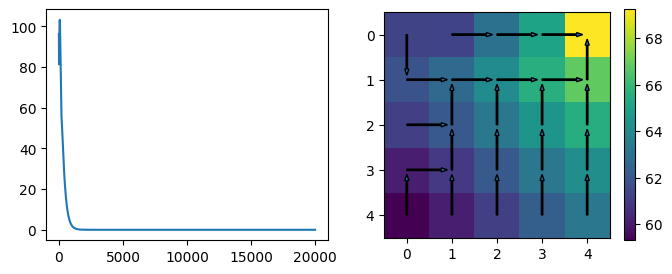

  1%|          | 235/20000 [00:00<00:17, 1142.72it/s]

66.39322379157677


  6%|▌         | 1138/20000 [00:01<00:18, 1017.37it/s]

3.3532861479204645


 11%|█         | 2211/20000 [00:01<00:13, 1299.98it/s]

0.18378936077964336


 16%|█▌        | 3153/20000 [00:02<00:09, 1716.54it/s]

0.01006242568998739


 21%|██        | 4205/20000 [00:02<00:08, 1920.70it/s]

0.0005509244136196994


 27%|██▋       | 5331/20000 [00:03<00:06, 2226.24it/s]

3.016349723653444e-05


 31%|███▏      | 6270/20000 [00:03<00:05, 2333.21it/s]

1.6514726404526117e-06


 36%|███▌      | 7126/20000 [00:04<00:07, 1754.27it/s]

9.041927765618393e-08


 41%|████▏     | 8263/20000 [00:05<00:06, 1832.52it/s]

4.950512981447762e-09


 47%|████▋     | 9389/20000 [00:05<00:05, 2038.13it/s]

2.717324379782316e-10


 52%|█████▏    | 10389/20000 [00:06<00:04, 2369.28it/s]

1.752011808558913e-11


 57%|█████▋    | 11398/20000 [00:06<00:03, 2450.68it/s]

1.0333524410560715e-11


 62%|██████▏   | 12405/20000 [00:06<00:03, 2466.61it/s]

1.0333524410560715e-11


 67%|██████▋   | 13378/20000 [00:07<00:02, 2394.00it/s]

1.0333524410560715e-11


 72%|███████▏  | 14335/20000 [00:07<00:02, 2351.27it/s]

1.0333524410560715e-11


 77%|███████▋  | 15455/20000 [00:08<00:01, 2813.12it/s]

1.0333524410560715e-11


 84%|████████▍ | 16780/20000 [00:08<00:00, 3830.27it/s]

1.0333524410560715e-11


 89%|████████▊ | 17707/20000 [00:08<00:00, 4254.08it/s]

1.0333524410560715e-11


 93%|█████████▎| 18580/20000 [00:08<00:00, 4313.62it/s]

1.0333524410560715e-11


 97%|█████████▋| 19484/20000 [00:09<00:00, 4350.84it/s]

1.0333524410560715e-11


100%|██████████| 20000/20000 [00:09<00:00, 2182.59it/s]


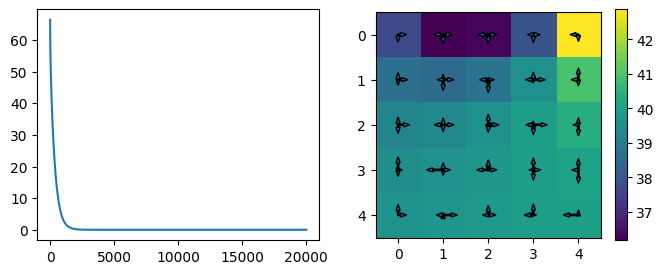

100%|██████████| 10000/10000 [00:05<00:00, 1887.84it/s]


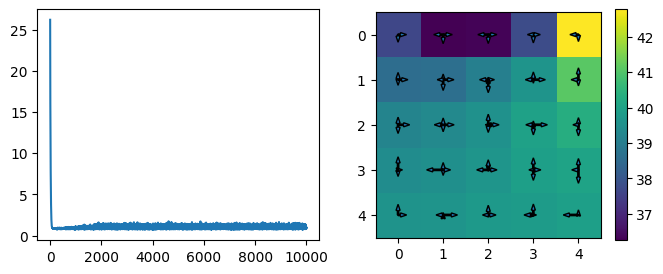

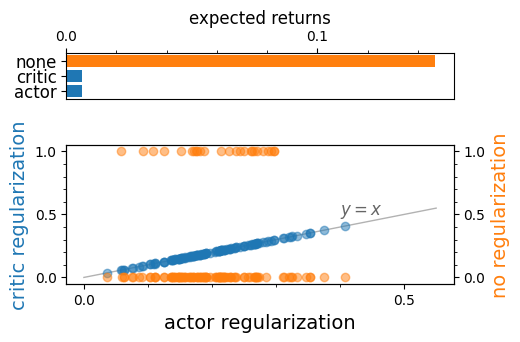

In [6]:
size = 5
num_states = size**2
num_actions = 5

def step(s, a):
  ij = np.array(np.unravel_index(s, (size, size)))
  if a == 0:
    ij[0] += 1
  elif a == 1:
    ij[1] += 1
  elif a == 2:
    ij[0] -= 1
  elif a == 3:
    ij[1] -= 1
  ij = ij.clip(0, size - 1)
  return np.ravel_multi_index(ij, (size, size))

def reward(s, a):
  return -1 * (0 < s) * (s < 4) + 1.5 * (s == 4) + 2.0
  # return (s == 4).astype(float)

initial_state = 0

def evaluate_pi(pi):
  p = np.zeros(num_states)
  p[initial_state] = 1
  p_ns_given_s = (p_ns_given_sa * pi[None]).sum(axis=-1)
  r_vec = []
  for t in range(1000):
    p_sa = p[:, None] * pi
    r = (r_sa * p_sa).sum()
    r_vec.append(r * gamma**t)
    p = p_ns_given_s @ p
  R1 = np.sum(r_vec)
  return R1

# collect static dataset
traj_vec = []

pi = np.ones((num_states, num_actions)) / 5.0

num_traj = 20
max_episode_steps = 50
np.random.seed(0)
for _ in tqdm.trange(num_traj):
  traj = []
  s = initial_state
  for __ in range(max_episode_steps):
    a = np.random.choice(num_actions, p=pi[s])
    traj.append((s, a))
    s = step(s, a)
  traj_vec.append(traj)
traj_vec = np.array(traj_vec)  # (num_traj, max_episode_steps, 2)

# SARSA, Q-learning
gamma = 0.95
learning_rate = 1e-2
for q_learning in [True, False]:
  use_sarsa = not q_learning
  regularize_policy = not q_learning

  np.random.seed(0)
  Q = np.random.normal(size=(num_states, num_actions))
  s_vec = traj_vec[:, :-1, 0].flatten()
  ns_vec = traj_vec[:, 1:, 0].flatten()
  a_vec = traj_vec[:, :-1, 1].flatten()
  na_vec = traj_vec[:, 1:, 1].flatten()
  r_vec = reward(s_vec, a_vec)
  diff_vec = []

  counts = np.zeros((num_states, num_actions))
  np.add.at(counts, (s_vec, a_vec), 1)
  beta = counts / counts.sum(axis=1, keepdims=True)
  assert np.all(np.isfinite(beta))

  for t in tqdm.trange(20_000):
    if use_sarsa:
      # V_vec = Q[ns_vec, na_vec]
      V_vec = (Q[ns_vec] * beta[ns_vec]).sum(axis=-1)
    else:
      V_vec = Q[ns_vec].max(-1)
    td_update = r_vec + gamma * V_vec - Q[s_vec, a_vec]
    diff = np.linalg.norm(td_update)
    diff_vec.append(diff)
    np.add.at(Q, (s_vec, a_vec), learning_rate * td_update)
    if t % 1000 == 0:
      print(diff)


  # policy extraction
  if regularize_policy:
    pi = (Q * beta).clip(0, None)  # Ignore negative Q values
    pi = pi / pi.sum(axis=1, keepdims=True)  # Normalize the probabilities
  else:
    pi = np.zeros((num_states, num_actions))
    pi[np.arange(num_states), Q.argmax(axis=1)] = 1

  plt.figure(figsize=(8, 3))
  plt.subplot(121)
  plt.plot(diff_vec)
  plt.subplot(122)
  plt.imshow(Q.mean(-1).reshape((size, size)))
  for s in range(num_states):
    for a, prob in enumerate(pi[s]):
      ns = step(s, a)
      if s != ns:
        ij = np.array(np.unravel_index(s, (size, size)))
        delta = np.array(np.unravel_index(ns, (size, size))) - ij
        delta = 0.9 *prob * delta
        plt.arrow(ij[1], ij[0], delta[1], delta[0], width=0.03, length_includes_head=True)

  plt.colorbar()
  plt.show()
  if q_learning:
    pi3 = pi.copy()
  else:
    pi1 = pi.copy()

# critic regularization
gamma = 0.95
learning_rate = 1e-3

np.random.seed(0)
Q = np.random.normal(size=(num_states, num_actions))
s_vec = traj_vec[:, :-1, 0].flatten()
ns_vec = traj_vec[:, 1:, 0].flatten()
a_vec = traj_vec[:, :-1, 1].flatten()
na_vec = traj_vec[:, 1:, 1].flatten()
r_vec = reward(s_vec, a_vec)
diff_vec = []
pi = np.ones((num_states, num_actions)) / num_actions

for t in tqdm.trange(10_000):
  V_vec = (Q[ns_vec] * pi[ns_vec]).sum(axis=-1)

  pos_weights = np.zeros((num_states, num_actions))
  y = r_vec + gamma * V_vec
  np.add.at(pos_weights, (s_vec, a_vec), y / (y + 1))
  neg_weights = np.zeros((num_states, num_actions))
  w = pi[s_vec, a_vec] / beta[s_vec, a_vec]
  np.add.at(neg_weights, (s_vec, a_vec), w / (y + 1))
  # Add epsilon to make the classifier in (0, 1)
  opt_classifier = pos_weights / (pos_weights + neg_weights + 1e-6)
  # opt_classifier = opt_classifier.clip(1e-6, 1 - 1e-6)
  diff_vec.append(np.linalg.norm(Q - opt_classifier / (1 - opt_classifier)))
  Q = opt_classifier / (1 - opt_classifier)

  # Do a small update to pi to ensure convergence
  pi_new = np.zeros((num_states, num_actions))
  pi_new[np.arange(num_states), Q.argmax(axis=1)] = 1
  pi += learning_rate * (pi_new - pi)

plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(diff_vec)
plt.subplot(122)
plt.imshow(Q.mean(-1).reshape((size, size)))
for s in range(num_states):
  for a, prob in enumerate(pi[s]):
    ns = step(s, a)
    if s != ns:
      ij = np.array(np.unravel_index(s, (size, size)))
      delta = np.array(np.unravel_index(ns, (size, size))) - ij
      delta = 0.9 *prob * delta
      plt.arrow(ij[1], ij[0], delta[1], delta[0], width=0.03, length_includes_head=True)

plt.colorbar()
plt.show()
Q2 = Q.copy()
pi2 = pi.copy()

plt.figure(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
plt.subplot(gs[0])

pi1_nan = pi1.copy()
pi1_nan[np.isnan(pi1_nan)] = 1 / num_actions
R1 = evaluate_pi(pi1_nan)
R2 = evaluate_pi(pi2)
R3 = evaluate_pi(pi3)
x = np.arange(3)
plt.barh(x, [R1, R2, R3], color=[c_vec[0], c_vec[0], c_vec[1]])
# plt.ylabel('regularization', fontsize=12)
plt.xlabel('expected returns', fontsize=12)
plt.gca().xaxis.set_label_position('top') 
plt.yticks(x, ['actor', 'critic', 'none'], fontsize=12)
plt.gca().xaxis.set_major_locator(MultipleLocator(0.1))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.02))
plt.gca().xaxis.tick_top()


plt.subplot(gs[1])
l = plt.plot([0, 0.55], [0, 0.55], '-', c='#666', linewidth=1, alpha=0.5)
plt.text(0.4, 0.5, '$y = x$', fontsize=12, c='#666')
plt.plot(pi1.flatten(), pi2.flatten(), 'o', alpha=0.5, c=c_vec[0])
plt.xlabel('actor regularization', fontsize=14)
plt.ylabel('critic regularization', fontsize=14, c=c_vec[0])
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid()
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.1))


plt.ylim([-0.05, 1.05])
ax2 = plt.twinx()
ax2.plot(pi1.flatten(), pi3.flatten(), 'o', c=c_vec[1], alpha=0.5)
ax2.set_ylabel('no regularization', fontsize=14, c=c_vec[1])
ax2.set_ylim([-0.05, 1.05])
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.subplots_adjust(hspace=0.5)
filename = '/tmp/gridworld_exp2.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()

### Experiment 1
random data, aim is to show that two methods converge to same strategy

In [7]:
size = 5
num_states = size**2
num_actions = 5

def step(s, a):
  ij = np.array(np.unravel_index(s, (size, size)))
  if a == 0:
    ij[0] += 1
  elif a == 1:
    ij[1] += 1
  elif a == 2:
    ij[0] -= 1
  elif a == 3:
    ij[1] -= 1
  ij = ij.clip(0, size - 1)
  return np.ravel_multi_index(ij, (size, size))

def reward(s, a):
  return (s == 24).astype(float)

initial_state = 0

def evaluate_pi(pi):
  p = np.zeros(num_states)
  p[initial_state] = 1
  p_ns_given_s = (p_ns_given_sa * pi[None]).sum(axis=-1)
  r_vec = []
  for t in range(1000):
    p_sa = p[:, None] * pi
    r = (r_sa * p_sa).sum()
    r_vec.append(r * gamma**t)
    p = p_ns_given_s @ p
  R1 = np.sum(r_vec)
  return R1

  
# collect static dataset
traj_vec = []

num_traj = 20
max_episode_steps = 50
np.random.seed(0)
for _ in tqdm.trange(num_traj):
  traj = []
  s = initial_state
  for __ in range(max_episode_steps):
    a = np.random.choice(num_actions)
    traj.append((s, a))
    s = step(s, a)
  traj_vec.append(traj)
traj_vec = np.array(traj_vec)  # (num_traj, max_episode_steps, 2)

100%|██████████| 20/20 [00:00<00:00, 282.98it/s]


100%|██████████| 20000/20000 [00:04<00:00, 4542.52it/s]


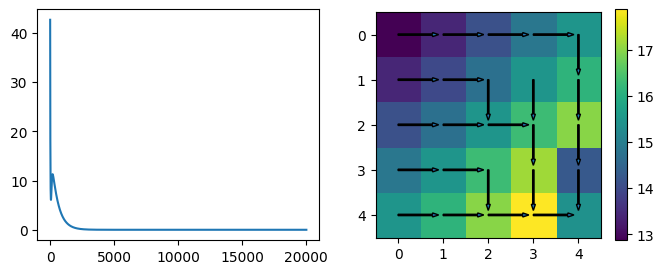

100%|██████████| 20000/20000 [00:09<00:00, 2104.11it/s]


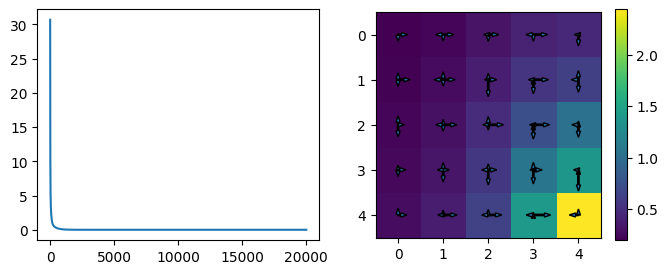

In [8]:
# SARSA, Q-learning
# TODO: When proving the equivalence, do we want to just use the empirical next state, or sample from the empirical behavioral policy. Note that these are different.

for q_learning in [True, False]:
  gamma = 0.95
  learning_rate = 1e-2
  use_sarsa = not q_learning
  regularize_policy = not q_learning

  np.random.seed(0)
  Q = np.random.normal(size=(num_states, num_actions))
  s_vec = traj_vec[:, :-1, 0].flatten()
  ns_vec = traj_vec[:, 1:, 0].flatten()
  a_vec = traj_vec[:, :-1, 1].flatten()
  na_vec = traj_vec[:, 1:, 1].flatten()
  r_vec = reward(s_vec, a_vec)
  diff_vec = []

  counts = np.zeros((num_states, num_actions))
  np.add.at(counts, (s_vec, a_vec), 1)
  beta = counts / counts.sum(axis=1, keepdims=True)
  assert np.all(np.isfinite(beta))

  for _ in tqdm.trange(20_000):
    if use_sarsa:
      # V_vec = Q[ns_vec, na_vec]
      V_vec = (Q[ns_vec] * beta[ns_vec]).sum(axis=-1)
    else:
      V_vec = Q[ns_vec].max(-1)
    td_update = r_vec + gamma * V_vec - Q[s_vec, a_vec]
    diff = np.linalg.norm(td_update)
    diff_vec.append(diff)
    np.add.at(Q, (s_vec, a_vec), learning_rate * td_update)


  # policy extraction
  if regularize_policy:
    pi = (Q * beta).clip(0, None)  # Ignore negative Q values
    pi = pi / pi.sum(axis=1, keepdims=True)  # Normalize the probabilities
  else:
    pi = np.zeros((num_states, num_actions))
    pi[np.arange(num_states), Q.argmax(axis=1)] = 1

  plt.figure(figsize=(8, 3))
  plt.subplot(121)
  plt.plot(diff_vec)
  plt.subplot(122)
  plt.imshow(Q.mean(-1).reshape((size, size)))
  for s in range(num_states):
    for a, prob in enumerate(pi[s]):
      ns = step(s, a)
      if s != ns:
        ij = np.array(np.unravel_index(s, (size, size)))
        delta = np.array(np.unravel_index(ns, (size, size))) - ij
        delta = 0.9 *prob * delta
        plt.arrow(ij[1], ij[0], delta[1], delta[0], width=0.03, length_includes_head=True)

  plt.colorbar()
  plt.show()
  if q_learning:
    Q3 = Q.copy()
    pi3 = pi.copy()
  else:
    Q1 = Q.copy()
    pi1 = pi.copy()

  0%|          | 186/40000 [00:00<00:42, 931.52it/s]

0 1.0261784771801261


  3%|▎         | 1058/40000 [00:01<00:50, 773.45it/s]

1000 0.7510505291194016


  5%|▌         | 2191/40000 [00:03<00:44, 856.44it/s]

2000 0.5775638839046959


  8%|▊         | 3128/40000 [00:04<00:48, 767.38it/s]

3000 0.4646624320398954


 10%|█         | 4088/40000 [00:05<00:54, 657.95it/s]

4000 0.3784985033053422


 13%|█▎        | 5068/40000 [00:07<01:01, 572.64it/s]

5000 0.31124780284818687


 15%|█▌        | 6079/40000 [00:08<00:29, 1168.54it/s]

6000 0.26068434029627674


 19%|█▊        | 7495/40000 [00:09<00:17, 1876.45it/s]

7000 0.22374431477355217


 20%|██        | 8175/40000 [00:09<00:21, 1481.59it/s]

8000 0.19497456816722986


 23%|██▎       | 9198/40000 [00:10<00:22, 1363.10it/s]

9000 0.17083871520040245


 25%|██▌       | 10126/40000 [00:11<00:26, 1124.09it/s]

10000 0.149721386850306


 28%|██▊       | 11241/40000 [00:11<00:20, 1396.58it/s]

11000 0.1311780712317666


 31%|███       | 12211/40000 [00:12<00:13, 2061.49it/s]

12000 0.11492004829687881


 33%|███▎      | 13230/40000 [00:13<00:20, 1324.52it/s]

13000 0.10052922304126499


 35%|███▌      | 14127/40000 [00:13<00:22, 1162.57it/s]

14000 0.08791810894778997


 38%|███▊      | 15213/40000 [00:14<00:17, 1398.66it/s]

15000 0.07707307920929053


 40%|████      | 16186/40000 [00:15<00:17, 1326.31it/s]

16000 0.06783992495899134


 43%|████▎     | 17138/40000 [00:16<00:17, 1315.87it/s]

17000 0.060572403227463725


 46%|████▌     | 18211/40000 [00:17<00:16, 1331.73it/s]

18000 0.05438805664675356


 48%|████▊     | 19256/40000 [00:17<00:17, 1206.60it/s]

19000 0.0490210980491253


 50%|█████     | 20105/40000 [00:18<00:26, 754.17it/s]

20000 0.04432257815852298


 53%|█████▎    | 21092/40000 [00:20<00:26, 726.14it/s]

21000 0.04008131651402501


 56%|█████▌    | 22214/40000 [00:22<00:22, 786.57it/s]

22000 0.03628703905300799


 58%|█████▊    | 23063/40000 [00:22<00:21, 789.42it/s]

23000 0.03284046590747596


 61%|██████    | 24240/40000 [00:24<00:12, 1243.40it/s]

24000 0.029722252344542253


 63%|██████▎   | 25140/40000 [00:24<00:13, 1121.99it/s]

25000 0.026871388678642368


 66%|██████▌   | 26236/40000 [00:25<00:10, 1277.30it/s]

26000 0.02434725597507204


 68%|██████▊   | 27183/40000 [00:26<00:09, 1305.10it/s]

27000 0.02203976763498058


 71%|███████   | 28230/40000 [00:27<00:09, 1251.73it/s]

28000 0.019920062381036656


 73%|███████▎  | 29209/40000 [00:27<00:07, 1407.36it/s]

29000 0.018035134973654093


 76%|███████▌  | 30201/40000 [00:28<00:07, 1266.22it/s]

30000 0.01633951457785781


 79%|███████▉  | 31528/40000 [00:29<00:04, 1960.88it/s]

31000 0.01476249595143245


 81%|████████  | 32287/40000 [00:29<00:03, 2331.78it/s]

32000 0.013351104434839037


 83%|████████▎ | 33367/40000 [00:30<00:02, 2605.17it/s]

33000 0.012106106936988064


 86%|████████▌ | 34440/40000 [00:30<00:02, 2567.95it/s]

34000 0.010932098712386932


 88%|████████▊ | 35238/40000 [00:31<00:01, 2538.24it/s]

35000 0.00989516869033688


 90%|█████████ | 36124/40000 [00:31<00:02, 1639.25it/s]

36000 0.008965410875700894


 93%|█████████▎| 37169/40000 [00:32<00:02, 1356.36it/s]

37000 0.008144109157904185


 95%|█████████▌| 38158/40000 [00:33<00:01, 1386.71it/s]

38000 0.0073512630647961695


 98%|█████████▊| 39273/40000 [00:33<00:00, 1369.94it/s]

39000 0.00665618428782244


100%|██████████| 40000/40000 [00:34<00:00, 1166.90it/s]


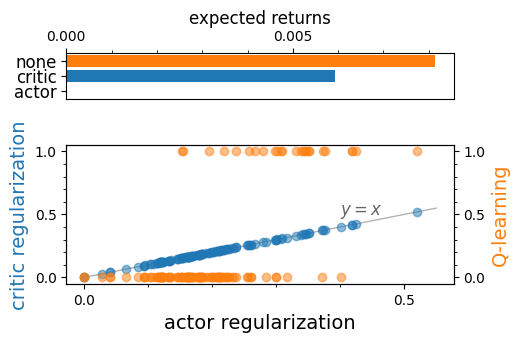

In [9]:
# critic regularization
gamma = 0.95
learning_rate = 1e-4

np.random.seed(0)
Q = np.random.normal(size=(num_states, num_actions))
s_vec = traj_vec[:, :-1, 0].flatten()
ns_vec = traj_vec[:, 1:, 0].flatten()
a_vec = traj_vec[:, :-1, 1].flatten()
na_vec = traj_vec[:, 1:, 1].flatten()
r_vec = reward(s_vec, a_vec)
diff_vec = []
pi = np.ones((num_states, num_actions)) / num_actions

for t in tqdm.trange(40_000):
  V_vec = (Q[ns_vec] * pi[ns_vec]).sum(axis=-1)

  pos_weights = np.zeros((num_states, num_actions))
  y = r_vec + gamma * V_vec
  np.add.at(pos_weights, (s_vec, a_vec), y / (y + 1))
  neg_weights = np.zeros((num_states, num_actions))
  w = pi[s_vec, a_vec] / beta[s_vec, a_vec]
  np.add.at(neg_weights, (s_vec, a_vec), w / (y + 1))
  # Add epsilon to make the classifier in (0, 1)
  opt_classifier = pos_weights / (pos_weights + neg_weights + 1e-12)
  # opt_classifier = opt_classifier.clip(1e-6, 1 - 1e-6)
  diff_vec.append(np.linalg.norm(Q - opt_classifier / (1 - opt_classifier)))
  Q = opt_classifier / (1 - opt_classifier)

  # Do a small update to pi to ensure convergence
  pi_new = np.zeros((num_states, num_actions))
  pi_new[np.arange(num_states), Q.argmax(axis=1)] = 1
  pi += learning_rate * (pi_new - pi)
  if t % 1000 == 0:
    print(t, np.linalg.norm(pi - pi1)), sklearn.metrics.r2_score(pi1.flatten(), pi.flatten())

Q2 = Q.copy()
pi2 = pi.copy()

c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
plt.subplot(gs[0])

pi1_nan = pi1.copy()
pi1_nan[np.isnan(pi1_nan)] = 1 / num_actions
R1 = 0.0  # evaluate_pi(pi1_nan)
R2 = evaluate_pi(pi2)
R3 = evaluate_pi(pi3)
x = np.arange(3)
plt.barh(x, [R1, R2, R3], color=[c_vec[0], c_vec[0], c_vec[1]])
# plt.ylabel('regularization', fontsize=12)
plt.xlabel('expected returns', fontsize=12)
plt.gca().xaxis.set_label_position('top') 
plt.yticks(x, ['actor', 'critic', 'none'], fontsize=12)
plt.gca().xaxis.set_major_locator(MultipleLocator(0.005))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.001))
plt.gca().xaxis.tick_top()

plt.subplot(gs[1])
l = plt.plot([0, 0.55], [0, 0.55], '-', c='#666', linewidth=1, alpha=0.5)
plt.text(0.4, 0.5, '$y = x$', fontsize=12, c='#666')
plt.plot(pi1.flatten(), pi2.flatten(), 'o', alpha=0.5, c=c_vec[0])
plt.xlabel('actor regularization', fontsize=14)
plt.ylabel('critic regularization', fontsize=14, c=c_vec[0])
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid()
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.1))


plt.ylim([-0.05, 1.05])
ax2 = plt.twinx()
ax2.plot(pi1.flatten(), pi3.flatten(), 'o', c=c_vec[1], alpha=0.5)
ax2.set_ylabel('Q-learning', fontsize=14, c=c_vec[1])
ax2.set_ylim([-0.05, 1.05])
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.subplots_adjust(hspace=0.5)
filename = '/tmp/gridworld_exp1.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()

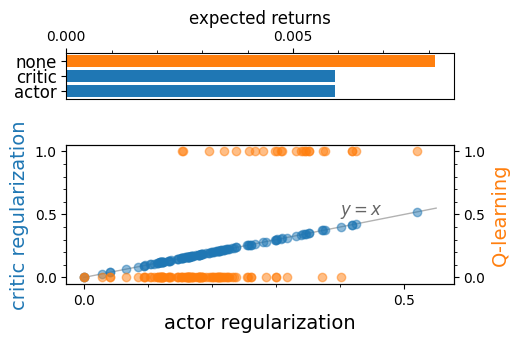

In [12]:
plt.figure(figsize=(5, 3))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])
plt.subplot(gs[0])

pi1_nan = pi1.copy()
pi1_nan[np.isnan(pi1_nan)] = 1 / num_actions
R1 = evaluate_pi(pi1_nan)
R2 = evaluate_pi(pi2)
R3 = evaluate_pi(pi3)
x = np.arange(3)
plt.barh(x, [R1, R2, R3], color=[c_vec[0], c_vec[0], c_vec[1]])
# plt.ylabel('regularization', fontsize=12)
plt.xlabel('expected returns', fontsize=12)
plt.gca().xaxis.set_label_position('top') 
plt.yticks(x, ['actor', 'critic', 'none'], fontsize=12)
plt.gca().xaxis.set_major_locator(MultipleLocator(0.005))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.001))
plt.gca().xaxis.tick_top()


plt.subplot(gs[1])
l = plt.plot([0, 0.55], [0, 0.55], '-', c='#666', linewidth=1, alpha=0.5)
plt.text(0.4, 0.5, '$y = x$', fontsize=12, c='#666')
plt.plot(pi1.flatten(), pi2.flatten(), 'o', alpha=0.5, c=c_vec[0])
plt.xlabel('actor regularization', fontsize=14)
plt.ylabel('critic regularization', fontsize=14, c=c_vec[0])
plt.gca().yaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().yaxis.set_minor_locator(MultipleLocator(0.1))
# plt.grid()
plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_minor_locator(MultipleLocator(0.1))


plt.ylim([-0.05, 1.05])
ax2 = plt.twinx()
ax2.plot(pi1.flatten(), pi3.flatten(), 'o', c=c_vec[1], alpha=0.5)
ax2.set_ylabel('Q-learning', fontsize=14, c=c_vec[1])
ax2.set_ylim([-0.05, 1.05])
ax2.yaxis.set_major_locator(MultipleLocator(0.5))
ax2.yaxis.set_minor_locator(MultipleLocator(0.1))

plt.subplots_adjust(hspace=0.5)
filename = '/tmp/gridworld_exp1.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()

### Example 1, varying CQL coefficient

In [ ]:
### Step 1: collect data
size = 5
num_states = size**2
num_actions = 5

def step(s, a):
  ij = np.array(np.unravel_index(s, (size, size)))
  if a == 0:
    ij[0] += 1
  elif a == 1:
    ij[1] += 1
  elif a == 2:
    ij[0] -= 1
  elif a == 3:
    ij[1] -= 1
  ij = ij.clip(0, size - 1)
  return np.ravel_multi_index(ij, (size, size))

def reward(s, a):
  return (s == 24).astype(float)

initial_state = 0

def evaluate_pi(pi):
  p = np.zeros(num_states)
  p[initial_state] = 1
  p_ns_given_s = (p_ns_given_sa * pi[None]).sum(axis=-1)
  r_vec = []
  for t in range(1000):
    p_sa = p[:, None] * pi
    r = (r_sa * p_sa).sum()
    r_vec.append(r * gamma**t)
    p = p_ns_given_s @ p
  R1 = np.sum(r_vec)
  return R1

  
# collect static dataset
traj_vec = []

num_traj = 20
max_episode_steps = 50
np.random.seed(0)
for _ in tqdm.trange(num_traj):
  traj = []
  s = initial_state
  for __ in range(max_episode_steps):
    a = np.random.choice(num_actions)
    traj.append((s, a))
    s = step(s, a)
  traj_vec.append(traj)
traj_vec = np.array(traj_vec)  # (num_traj, max_episode_steps, 2)

100%|██████████| 20/20 [00:00<00:00, 428.76it/s]


In [ ]:
# actor regularization
# TODO: When proving the equivalence, do we want to just use the empirical next state, or sample from the empirical behavioral policy. Note that these are different.

gamma = 0.95
learning_rate = 1e-2
use_sarsa = True
regularize_policy = True

np.random.seed(0)
Q = np.random.normal(size=(num_states, num_actions))
s_vec = traj_vec[:, :-1, 0].flatten()
ns_vec = traj_vec[:, 1:, 0].flatten()
a_vec = traj_vec[:, :-1, 1].flatten()
na_vec = traj_vec[:, 1:, 1].flatten()
r_vec = reward(s_vec, a_vec)
diff_vec = []

counts = np.zeros((num_states, num_actions))
np.add.at(counts, (s_vec, a_vec), 1)
beta = counts / counts.sum(axis=1, keepdims=True)
assert np.all(np.isfinite(beta))

for _ in tqdm.trange(20_000):
  V_vec = (Q[ns_vec] * beta[ns_vec]).sum(axis=-1)
  td_update = r_vec + gamma * V_vec - Q[s_vec, a_vec]
  diff = np.linalg.norm(td_update)
  diff_vec.append(diff)
  np.add.at(Q, (s_vec, a_vec), learning_rate * td_update)


# policy extraction
pi = (Q * beta).clip(0, None)  # Ignore negative Q values
pi = pi / pi.sum(axis=1, keepdims=True)  # Normalize the probabilities

Q1 = Q.copy()
pi1 = pi.copy()

100%|██████████| 20000/20000 [00:05<00:00, 3812.28it/s]


In [ ]:
# critic regularization
gamma = 0.95
learning_rate = 1e-4
np.random.seed(0)

L_vec = np.logspace(-1, 1, 7)
R_vec = []
num_seeds = 1
for L in L_vec:
  print('L = %s' % L)
  vec = []
  for _ in tqdm.trange(num_seeds):
    Q = np.random.normal(size=(num_states, num_actions))
    s_vec = traj_vec[:, :-1, 0].flatten()
    ns_vec = traj_vec[:, 1:, 0].flatten()
    a_vec = traj_vec[:, :-1, 1].flatten()
    na_vec = traj_vec[:, 1:, 1].flatten()
    r_vec = reward(s_vec, a_vec)
    diff_vec = []
    pi = np.ones((num_states, num_actions)) / num_actions

    for t in range(40_000):  # TODO(eysenbach): increase to 40k
      V_vec = (Q[ns_vec] * pi[ns_vec]).sum(axis=-1)

      pos_weights = np.zeros((num_states, num_actions))
      y = r_vec + gamma * V_vec
      np.add.at(pos_weights, (s_vec, a_vec), y / (y + 1))
      neg_weights = np.zeros((num_states, num_actions))
      w = pi[s_vec, a_vec] / beta[s_vec, a_vec]
      w = L * w + (1 - L)
      np.add.at(neg_weights, (s_vec, a_vec), w / (y + 1))
      # Add epsilon to make the classifier in (0, 1)
      opt_classifier = pos_weights / (pos_weights + neg_weights + 1e-12)
      # opt_classifier = opt_classifier.clip(1e-6, 1 - 1e-6)
      diff_vec.append(np.linalg.norm(Q - opt_classifier / (1 - opt_classifier)))
      Q = opt_classifier / (1 - opt_classifier)

      # Do a small update to pi to ensure convergence
      pi_new = np.zeros((num_states, num_actions))
      pi_new[np.arange(num_states), Q.argmax(axis=1)] = 1
      pi += learning_rate * (pi_new - pi)
      if t % 1000 == 0:
        R2 = np.mean(pi1.argmax(axis=1) == pi.argmax(axis=1))
        print('(t=%d) R^2=%.3f' % (t, R2))  # sklearn.metrics.r2_score(pi1.flatten(), pi.flatten())))
    # R2 = sklearn.metrics.r2_score(pi1.flatten(), pi.flatten())
    R2 = np.mean(pi1.argmax(axis=1) == pi.argmax(axis=1))
    vec.append(R2)
  R_vec.append(vec)
    # Q2 = Q.copy()
    # pi2 = pi.copy()

L = 0.1


  0%|          | 0/1 [00:00<?, ?it/s]

(t=0) R^2=0.240
(t=1000) R^2=0.680
(t=2000) R^2=0.720
(t=3000) R^2=0.760
(t=4000) R^2=0.720
(t=5000) R^2=0.720
(t=6000) R^2=0.720
(t=7000) R^2=0.680
(t=8000) R^2=0.680
(t=9000) R^2=0.680
(t=10000) R^2=0.680
(t=11000) R^2=0.640
(t=12000) R^2=0.640
(t=13000) R^2=0.640
(t=14000) R^2=0.640
(t=15000) R^2=0.640
(t=16000) R^2=0.640
(t=17000) R^2=0.640
(t=18000) R^2=0.640
(t=19000) R^2=0.640
(t=20000) R^2=0.640
(t=21000) R^2=0.640
(t=22000) R^2=0.640
(t=23000) R^2=0.640
(t=24000) R^2=0.640
(t=25000) R^2=0.640
(t=26000) R^2=0.640
(t=27000) R^2=0.640
(t=28000) R^2=0.640
(t=29000) R^2=0.640
(t=30000) R^2=0.640
(t=31000) R^2=0.640
(t=32000) R^2=0.640
(t=33000) R^2=0.640
(t=34000) R^2=0.640
(t=35000) R^2=0.640
(t=36000) R^2=0.640
(t=37000) R^2=0.640
(t=38000) R^2=0.640
(t=39000) R^2=0.640

100%|██████████| 1/1 [00:18<00:00, 18.79s/it]


L = 0.21544346900318834

  0%|          | 0/1 [00:00<?, ?it/s]

(t=0) R^2=0.320
(t=1000) R^2=0.800
(t=2000) R^2=0.800
(t=3000) R^2=0.800
(t=4000) R^2=0.800
(t=5000) R^2=0.800
(t=6000) R^2=0.800
(t=7000) R^2=0.800
(t=8000) R^2=0.800
(t=9000) R^2=0.800
(t=10000) R^2=0.800
(t=11000) R^2=0.800
(t=12000) R^2=0.800
(t=13000) R^2=0.800
(t=14000) R^2=0.800
(t=15000) R^2=0.800
(t=16000) R^2=0.800
(t=17000) R^2=0.800
(t=18000) R^2=0.800
(t=19000) R^2=0.800
(t=20000) R^2=0.800
(t=21000) R^2=0.800
(t=22000) R^2=0.800
(t=23000) R^2=0.800
(t=24000) R^2=0.800
(t=25000) R^2=0.800
(t=26000) R^2=0.800
(t=27000) R^2=0.800
(t=28000) R^2=0.800
(t=29000) R^2=0.800
(t=30000) R^2=0.800
(t=31000) R^2=0.800
(t=32000) R^2=0.800
(t=33000) R^2=0.800
(t=34000) R^2=0.800
(t=35000) R^2=0.800
(t=36000) R^2=0.800
(t=37000) R^2=0.800
(t=38000) R^2=0.800
(t=39000) R^2=0.800

100%|██████████| 1/1 [00:18<00:00, 18.80s/it]


L = 0.46415888336127786

  0%|          | 0/1 [00:00<?, ?it/s]

(t=0) R^2=0.280
(t=1000) R^2=0.800
(t=2000) R^2=0.800
(t=3000) R^2=0.800
(t=4000) R^2=0.800
(t=5000) R^2=0.800
(t=6000) R^2=0.800
(t=7000) R^2=0.800
(t=8000) R^2=0.840
(t=9000) R^2=0.840
(t=10000) R^2=0.840
(t=11000) R^2=0.880
(t=12000) R^2=0.880
(t=13000) R^2=0.880
(t=14000) R^2=0.880
(t=15000) R^2=0.880
(t=16000) R^2=0.880
(t=17000) R^2=0.880
(t=18000) R^2=0.840
(t=19000) R^2=0.840
(t=20000) R^2=0.840
(t=21000) R^2=0.840
(t=22000) R^2=0.840
(t=23000) R^2=0.840
(t=24000) R^2=0.840
(t=25000) R^2=0.880
(t=26000) R^2=0.880
(t=27000) R^2=0.880
(t=28000) R^2=0.880
(t=29000) R^2=0.880
(t=30000) R^2=0.840
(t=31000) R^2=0.840
(t=32000) R^2=0.840
(t=33000) R^2=0.840
(t=34000) R^2=0.840
(t=35000) R^2=0.840
(t=36000) R^2=0.840
(t=37000) R^2=0.880
(t=38000) R^2=0.880
(t=39000) R^2=0.880

100%|██████████| 1/1 [00:18<00:00, 18.60s/it]


L = 1.0

  0%|          | 0/1 [00:00<?, ?it/s]

(t=0) R^2=0.440
(t=1000) R^2=1.000
(t=2000) R^2=1.000
(t=3000) R^2=0.960
(t=4000) R^2=0.960
(t=5000) R^2=0.960
(t=6000) R^2=1.000
(t=7000) R^2=1.000
(t=8000) R^2=0.960
(t=9000) R^2=0.960
(t=10000) R^2=1.000
(t=11000) R^2=0.960
(t=12000) R^2=0.960
(t=13000) R^2=0.960
(t=14000) R^2=1.000
(t=15000) R^2=1.000
(t=16000) R^2=0.960
(t=17000) R^2=0.960
(t=18000) R^2=1.000
(t=19000) R^2=1.000
(t=20000) R^2=0.960
(t=21000) R^2=0.960
(t=22000) R^2=0.960
(t=23000) R^2=1.000
(t=24000) R^2=1.000
(t=25000) R^2=0.960
(t=26000) R^2=1.000
(t=27000) R^2=1.000
(t=28000) R^2=1.000
(t=29000) R^2=1.000
(t=30000) R^2=0.960
(t=31000) R^2=1.000
(t=32000) R^2=1.000
(t=33000) R^2=0.960
(t=34000) R^2=0.960
(t=35000) R^2=0.960
(t=36000) R^2=1.000
(t=37000) R^2=1.000
(t=38000) R^2=0.960
(t=39000) R^2=0.960

100%|██████████| 1/1 [00:18<00:00, 18.21s/it]


L = 2.1544346900318834

  0%|          | 0/1 [00:00<?, ?it/s]

(t=0) R^2=0.200
(t=1000) R^2=0.640
(t=2000) R^2=0.640
(t=3000) R^2=0.680
(t=4000) R^2=0.680
(t=5000) R^2=0.640
(t=6000) R^2=0.800
(t=7000) R^2=0.720
(t=8000) R^2=0.720
(t=9000) R^2=0.720
(t=10000) R^2=0.760
(t=11000) R^2=0.760
(t=12000) R^2=0.760
(t=13000) R^2=0.760
(t=14000) R^2=0.760
(t=15000) R^2=0.720
(t=16000) R^2=0.720
(t=17000) R^2=0.720
(t=18000) R^2=0.760
(t=19000) R^2=0.760
(t=20000) R^2=0.760
(t=21000) R^2=0.760
(t=22000) R^2=0.720
(t=23000) R^2=0.760
(t=24000) R^2=0.720
(t=25000) R^2=0.720
(t=26000) R^2=0.720
(t=27000) R^2=0.760
(t=28000) R^2=0.760
(t=29000) R^2=0.760
(t=30000) R^2=0.760
(t=31000) R^2=0.720
(t=32000) R^2=0.720
(t=33000) R^2=0.720
(t=34000) R^2=0.720
(t=35000) R^2=0.720
(t=36000) R^2=0.760
(t=37000) R^2=0.760
(t=38000) R^2=0.760
(t=39000) R^2=0.720

100%|██████████| 1/1 [00:17<00:00, 17.02s/it]


L = 4.6415888336127775

  0%|          | 0/1 [00:00<?, ?it/s]

(t=0) R^2=0.320
(t=1000) R^2=0.320
(t=2000) R^2=0.280
(t=3000) R^2=0.400
(t=4000) R^2=0.400
(t=5000) R^2=0.400
(t=6000) R^2=0.400
(t=7000) R^2=0.400
(t=8000) R^2=0.400
(t=9000) R^2=0.400
(t=10000) R^2=0.400
(t=11000) R^2=0.400
(t=12000) R^2=0.400
(t=13000) R^2=0.400
(t=14000) R^2=0.400
(t=15000) R^2=0.400
(t=16000) R^2=0.400
(t=17000) R^2=0.400
(t=18000) R^2=0.400
(t=19000) R^2=0.400
(t=20000) R^2=0.400
(t=21000) R^2=0.400
(t=22000) R^2=0.400
(t=23000) R^2=0.400
(t=24000) R^2=0.400
(t=25000) R^2=0.400
(t=26000) R^2=0.400
(t=27000) R^2=0.400
(t=28000) R^2=0.400
(t=29000) R^2=0.400
(t=30000) R^2=0.400
(t=31000) R^2=0.400
(t=32000) R^2=0.400
(t=33000) R^2=0.400
(t=34000) R^2=0.400
(t=35000) R^2=0.400
(t=36000) R^2=0.400
(t=37000) R^2=0.400
(t=38000) R^2=0.400
(t=39000) R^2=0.400

<ipython-input-35-70ae30909038>:35: RuntimeWarning: divide by zero encountered in divide
  diff_vec.append(np.linalg.norm(Q - opt_classifier / (1 - opt_classifier)))
<ipython-input-35-70ae30909038>:36: RuntimeWarning: divide by zero encountered in divide
  Q = opt_classifier / (1 - opt_classifier)
<ipython-input-35-70ae30909038>:27: RuntimeWarning: invalid value encountered in divide
  np.add.at(pos_weights, (s_vec, a_vec), y / (y + 1))
100%|██████████| 1/1 [00:17<00:00, 17.47s/it]


L = 10.0

  0%|          | 0/1 [00:00<?, ?it/s]

(t=0) R^2=0.200
(t=1000) R^2=0.400
(t=2000) R^2=0.400
(t=3000) R^2=0.400
(t=4000) R^2=0.400
(t=5000) R^2=0.400
(t=6000) R^2=0.400
(t=7000) R^2=0.400
(t=8000) R^2=0.400
(t=9000) R^2=0.400
(t=10000) R^2=0.400
(t=11000) R^2=0.400
(t=12000) R^2=0.400
(t=13000) R^2=0.400
(t=14000) R^2=0.400
(t=15000) R^2=0.400
(t=16000) R^2=0.400
(t=17000) R^2=0.400
(t=18000) R^2=0.400
(t=19000) R^2=0.400
(t=20000) R^2=0.400
(t=21000) R^2=0.400
(t=22000) R^2=0.400
(t=23000) R^2=0.400
(t=24000) R^2=0.400
(t=25000) R^2=0.400
(t=26000) R^2=0.400
(t=27000) R^2=0.400
(t=28000) R^2=0.400
(t=29000) R^2=0.400
(t=30000) R^2=0.400
(t=31000) R^2=0.400
(t=32000) R^2=0.400
(t=33000) R^2=0.400
(t=34000) R^2=0.400
(t=35000) R^2=0.400
(t=36000) R^2=0.400
(t=37000) R^2=0.400
(t=38000) R^2=0.400
(t=39000) R^2=0.400

100%|██████████| 1/1 [00:18<00:00, 18.59s/it]

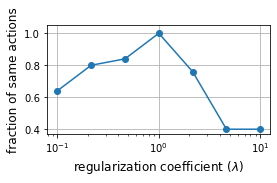

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
c_vec = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.figure(figsize=(4, 2))
mu = np.mean(R_vec, axis=1)
std = np.std(R_vec, axis=1)
plt.plot(L_vec, mu, '-o', c=c_vec[0])
plt.fill_between(L_vec, mu-std, mu+std, fc=c_vec[0], alpha=0.2)
plt.xlabel('regularization coefficient ($\lambda$)', fontsize=12)
plt.ylabel('fraction of same actions', fontsize=12)
plt.xscale('log')
plt.ylim([None, 1.05])
plt.grid()
filename = '/tmp/tabular_similarity.pdf'
plt.savefig(filename, bbox_inches='tight')
plt.show()